In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, length, dayofweek, to_timestamp, concat, lit, udf, when
from pyspark.sql.types import DoubleType, StringType
spark = SparkSession.builder.appName('iteration4').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 20:55:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

## 2 Data Understanding

### 2.1 Data Collection

In [3]:
# read data
customer_details = spark.read.csv('customer_details.csv', header=True, inferSchema=True)
product_details = spark.read.csv('product_details.csv', header=True, inferSchema=True)
sales_data = spark.read.csv('E-commerce sales data 2024.csv', header=True, inferSchema=True)

In [4]:
# first 5 rows of data
customer_details.toPandas().head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [5]:
product_details.toPandas().head()

24/05/23 20:55:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Uniqe Id,Product Name,Brand Name,Asin,Category,Upc Ean Code,List Price,Selling Price,Quantity,Model Number,...,Product Url,Stock,Product Details,Dimensions,Color,Ingredients,Direction To Use,Is Amazon Seller,Size Quantity Variant,Product Description
0,4c69b61db1fc16e7013b43fc926e502d,"""DB Longboards CoreFlex Crossbow 41"""" Bamboo F...",None,None,Sports & Outdoors | Outdoor Recreation | Skate...,None,None,$237.68,None,None,...,https://www.amazon.com/DB-Longboards-CoreFlex-...,None,None,None,None,None,None,Y,None,None
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",None,None,Toys & Games | Learning & Education | Science ...,None,None,$99.95,None,55324,...,https://www.amazon.com/Electronic-Circuits-Cla...,None,None,None,None,None,None,Y,None,None
2,2c55cae269aebf53838484b0d7dd931a,3Doodler Create Flexy 3D Printing Filament Ref...,None,None,Toys & Games | Arts & Crafts | Craft Kits,None,None,$34.99,None,None,...,https://www.amazon.com/3Doodler-Plastic-Innova...,None,None,None,None,None,None,Y,None,None
3,18018b6bc416dab347b1b7db79994afa,Guillow Airplane Design Studio with Travel Cas...,None,None,Toys & Games | Hobbies | Models & Model Kits |...,None,None,$28.91,None,142,...,https://www.amazon.com/Guillow-Airplane-Design...,None,None,None,None,None,None,Y,None,None
4,e04b990e95bf73bbe6a3fa09785d7cd0,Woodstock- Collage 500 pc Puzzle,None,None,Toys & Games | Puzzles | Jigsaw Puzzles,None,None,$17.49,None,62151,...,https://www.amazon.com/Woodstock-Collage-500-p...,None,None,None,None,None,None,Y,None,None


In [6]:
sales_data.toPandas().head()

24/05/23 20:55:29 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: user id, product id, Interaction type, Time stamp, 
 Schema: user id, product id, Interaction type, Time stamp, _c4
Expected: _c4 but found: 
CSV file: file:///home/ubuntu/iteration4/E-commerce%20sales%20data%202024.csv


,user id,product id,Interaction type,Time stamp,_c4
0,1.0,4c69b61db1fc16e7013b43fc926e502d,purchase,10/10/2023 8:00,None
1,2.0,66d49bbed043f5be260fa9f7fbff5957,view,11/10/2023 8:00,None
2,3.0,2c55cae269aebf53838484b0d7dd931a,like,12/10/2023 8:00,None
3,4.0,18018b6bc416dab347b1b7db79994afa,view,13/10/2023 8:00,None
4,5.0,e04b990e95bf73bbe6a3fa09785d7cd0,like,14/10/2023 8:00,None


### 2.2 Data Description

In [7]:
# column names, data type and null values
customer_details.printSchema()
customer_null = {col:customer_details.filter(customer_details[col].isNull()).count() for col in customer_details.columns}
customer_null

root
 |-- Customer ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Item Purchased: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Purchase Amount (USD): integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Review Rating: double (nullable = true)
 |-- Subscription Status: string (nullable = true)
 |-- Shipping Type: string (nullable = true)
 |-- Discount Applied: string (nullable = true)
 |-- Promo Code Used: string (nullable = true)
 |-- Previous Purchases: integer (nullable = true)
 |-- Payment Method: string (nullable = true)
 |-- Frequency of Purchases: string (nullable = true)



{'Customer ID': 0,
 'Age': 0,
 'Gender': 0,
 'Item Purchased': 0,
 'Category': 0,
 'Purchase Amount (USD)': 0,
 'Location': 0,
 'Size': 0,
 'Color': 0,
 'Season': 0,
 'Review Rating': 0,
 'Subscription Status': 0,
 'Shipping Type': 0,
 'Discount Applied': 0,
 'Promo Code Used': 0,
 'Previous Purchases': 0,
 'Payment Method': 0,
 'Frequency of Purchases': 0}

In [8]:
product_details.printSchema()
product_null = {col:product_details.filter(product_details[col].isNull()).count() for col in product_details.columns}
product_null

root
 |-- Uniqe Id: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Brand Name: string (nullable = true)
 |-- Asin: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Upc Ean Code: string (nullable = true)
 |-- List Price: string (nullable = true)
 |-- Selling Price: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Model Number: string (nullable = true)
 |-- About Product: string (nullable = true)
 |-- Product Specification: string (nullable = true)
 |-- Technical Details: string (nullable = true)
 |-- Shipping Weight: string (nullable = true)
 |-- Product Dimensions: string (nullable = true)
 |-- Image: string (nullable = true)
 |-- Variants: string (nullable = true)
 |-- Sku: string (nullable = true)
 |-- Product Url: string (nullable = true)
 |-- Stock: string (nullable = true)
 |-- Product Details: string (nullable = true)
 |-- Dimensions: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Ingredients

{'Uniqe Id': 0,
 'Product Name': 0,
 'Brand Name': 9567,
 'Asin': 9893,
 'Category': 1213,
 'Upc Ean Code': 9646,
 'List Price': 9921,
 'Selling Price': 518,
 'Quantity': 9669,
 'Model Number': 2066,
 'About Product': 372,
 'Product Specification': 1493,
 'Technical Details': 830,
 'Shipping Weight': 1091,
 'Product Dimensions': 7846,
 'Image': 542,
 'Variants': 6583,
 'Sku': 8742,
 'Product Url': 923,
 'Stock': 8731,
 'Product Details': 9081,
 'Dimensions': 9310,
 'Color': 9465,
 'Ingredients': 9559,
 'Direction To Use': 9643,
 'Is Amazon Seller': 1583,
 'Size Quantity Variant': 9233,
 'Product Description': 9456}

In [9]:
sales_data.printSchema()
sales_null = {col:sales_data.filter(sales_data[col].isNull()).count() for col in sales_data.columns}
sales_null

root
 |-- user id: integer (nullable = true)
 |-- product id: string (nullable = true)
 |-- Interaction type: string (nullable = true)
 |-- Time stamp: string (nullable = true)
 |-- _c4: string (nullable = true)



24/05/23 20:55:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c4
Expected: _c4 but found: 
CSV file: file:///home/ubuntu/iteration4/E-commerce%20sales%20data%202024.csv


{'user id': 295,
 'product id': 295,
 'Interaction type': 423,
 'Time stamp': 295,
 '_c4': 3294}

### 2.3 Data Exploration

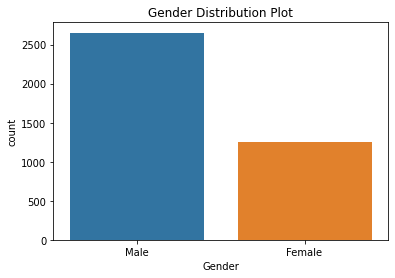

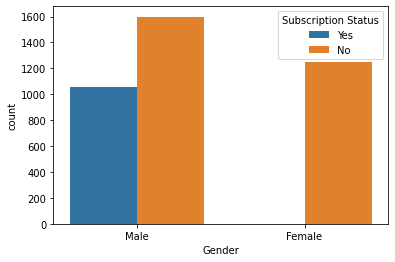

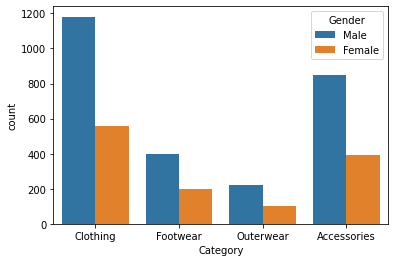

In [10]:
# data visualisation
pd_customer_details = customer_details.toPandas()

# gender count
sns.countplot(data=pd_customer_details, x='Gender') 
plt.title("Gender Distribution Plot") 
  
plt.show()

# gender with subscription status
sns.countplot(data=pd_customer_details, x='Gender', hue='Subscription Status') 
  
plt.show()

# gender with category of purchased items
sns.countplot(data=pd_customer_details, x='Category', hue='Gender') 
  
plt.show()

In [11]:
pd_customer_details.groupby(['Category', 'Gender']).count()['Customer ID']

Category     Gender
Accessories  Female     392
             Male       848
Clothing     Female     556
             Male      1181
Footwear     Female     199
             Male       400
Outerwear    Female     101
             Male       223
Name: Customer ID, dtype: int64

52


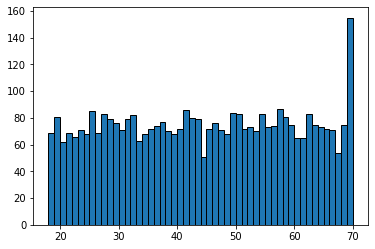

In [12]:
# number of bins
print(pd_customer_details['Age'].max() - pd_customer_details['Age'].min())

# age distribution
plt.hist(data=pd_customer_details, x='Age', edgecolor="black", bins=52) 
  
plt.show()

Discount Applied  Subscription Status
No                No                     2223
Yes               No                      624
                  Yes                    1053
Name: Customer ID, dtype: int64


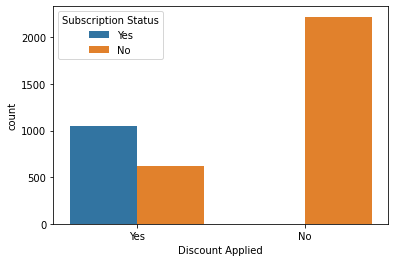

In [13]:
print(pd_customer_details.groupby(['Discount Applied', 'Subscription Status']).count()['Customer ID'])

# discount applied with subscription status
sns.countplot(data=pd_customer_details, x='Discount Applied', hue='Subscription Status') 
  
plt.show()

24/05/23 20:55:49 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: user id, product id, Interaction type, Time stamp, 
 Schema: user id, product id, Interaction type, Time stamp, _c4
Expected: _c4 but found: 
CSV file: file:///home/ubuntu/iteration4/E-commerce%20sales%20data%202024.csv


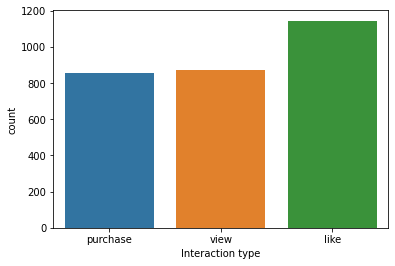

In [14]:
pd_sales_data = sales_data.toPandas()

# interaction type of product
sns.countplot(data=pd_sales_data, x='Interaction type') 
  
plt.show()

### 2.4 Verify Data Quality

In [15]:
# show number of null values in data
print(sales_null)

# show number of rows in sales_data
sales_data.count()

{'user id': 295, 'product id': 295, 'Interaction type': 423, 'Time stamp': 295, '_c4': 3294}


3294

In [16]:
# first 5 rows of interaction type with null values
sales_data.filter("`Interaction type` is null").show(5)

+-------+--------------------+----------------+----------------+----+
|user id|          product id|Interaction type|      Time stamp| _c4|
+-------+--------------------+----------------+----------------+----+
|    276|d49b828318fdd2a55...|            null|23/03/2023 10:00|null|
|    277|90f3d45ebaa97aabd...|            null|24/03/2023 10:00|null|
|    553|693ba00b2a5afe284...|            null| 23/12/2023 8:00|null|
|    908|86927a1ecbd562feb...|            null| 12/11/2023 8:00|null|
|    909|2efb24558840733ca...|            null| 13/11/2023 8:00|null|
+-------+--------------------+----------------+----------------+----+
only showing top 5 rows



24/05/23 20:55:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: user id, product id, Interaction type, Time stamp, 
 Schema: user id, product id, Interaction type, Time stamp, _c4
Expected: _c4 but found: 
CSV file: file:///home/ubuntu/iteration4/E-commerce%20sales%20data%202024.csv


In [17]:
# rows with all null values
sales_data.filter("`user id` is null AND `product id` is null AND `Interaction type` is null AND `Time stamp` is null").count()

295

In [18]:
# show number of null values in data
print(product_null)

# show number of rows in product_details
product_details.count()

{'Uniqe Id': 0, 'Product Name': 0, 'Brand Name': 9567, 'Asin': 9893, 'Category': 1213, 'Upc Ean Code': 9646, 'List Price': 9921, 'Selling Price': 518, 'Quantity': 9669, 'Model Number': 2066, 'About Product': 372, 'Product Specification': 1493, 'Technical Details': 830, 'Shipping Weight': 1091, 'Product Dimensions': 7846, 'Image': 542, 'Variants': 6583, 'Sku': 8742, 'Product Url': 923, 'Stock': 8731, 'Product Details': 9081, 'Dimensions': 9310, 'Color': 9465, 'Ingredients': 9559, 'Direction To Use': 9643, 'Is Amazon Seller': 1583, 'Size Quantity Variant': 9233, 'Product Description': 9456}


10002

In [19]:
product_details.select('Selling Price').show()

+-------------+
|Selling Price|
+-------------+
|      $237.68|
|       $99.95|
|       $34.99|
|       $28.91|
|       $17.49|
|       $18.66|
|       $29.12|
|       $97.68|
|         null|
|       $38.49|
|       $18.16|
|       $84.61|
|       $33.92|
|       $14.99|
|        $4.99|
|       $34.39|
|       $12.88|
|      $117.26|
|        $9.39|
|       $17.85|
+-------------+
only showing top 20 rows



## 3 Data Preparation

### 3.2 Clean Data

In [20]:
# select first 4 columns
sales_data = sales_data.drop('_c4')

# remove rows with any null value
sales_data = sales_data.dropna()

# check if any null value exists
print({col:sales_data.filter(sales_data[col].isNull()).count() for col in sales_data.columns})

# number of rows and number of columns
sales_shape = (sales_data.count(), len(sales_data.columns))
print(sales_shape)

{'user id': 0, 'product id': 0, 'Interaction type': 0, 'Time stamp': 0}
(2871, 4)


In [21]:
# select columns
product_details = product_details.select('Uniqe id', 'Category', 'Is Amazon Seller', 'Selling Price')

# remove rows with any null value
product_details = product_details.dropna()

# check if any null value exists
print({col:product_details.filter(product_details[col].isNull()).count() for col in product_details.columns})

# number of rows and number of columns
product_shape = (product_details.count(), len(product_details.columns))
print(product_shape)

{'Uniqe id': 0, 'Category': 0, 'Is Amazon Seller': 0, 'Selling Price': 0}
(7567, 4)


In [22]:
# selling price values
product_details.select('Selling Price').distinct().show()

+---------------+
|  Selling Price|
+---------------+
|          $9.51|
|         $45.36|
|         $34.91|
|          $1.41|
|         $13.37|
|        $146.87|
|         $36.12|
|         $20.08|
|         $23.93|
|         $32.86|
|$20.93 - $30.93|
|         $19.41|
|          $4.30|
|          $9.97|
|          $5.52|
|          $9.52|
|         $19.03|
|         $50.88|
|         $19.28|
|         $59.97|
+---------------+
only showing top 20 rows



In [23]:
# remove rows contains selling price that defines a range
product_details = product_details.filter(length(col("Selling Price")) <= 10)

# remove dollar signs
product_details = product_details.withColumn("Selling Price", regexp_replace(col("Selling Price"), "\\$", "")\
                                             .cast(DoubleType()))

# selling price values and type
product_details.select('Selling Price').distinct().show()
product_details.printSchema()

+-------------+
|Selling Price|
+-------------+
|        19.98|
|        17.95|
|         14.9|
|         15.5|
|        10.65|
|        40.11|
|         49.8|
|         8.51|
|        76.98|
|        40.53|
|         6.96|
|        24.42|
|        19.27|
|         5.86|
|        16.54|
|        20.49|
|        16.75|
|         5.05|
|        11.53|
|         8.73|
+-------------+
only showing top 20 rows

root
 |-- Uniqe id: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Is Amazon Seller: string (nullable = true)
 |-- Selling Price: double (nullable = true)



In [24]:
# select columns
customer_details = customer_details.select('Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category', \
                                           'Season', 'Subscription Status', 'Discount Applied')

# check if any null value exists
print({col:customer_details.filter(customer_details[col].isNull()).count() for col in customer_details.columns})

# number of rows and number of columns
customer_shape = (customer_details.count(), len(customer_details.columns))
print(customer_shape)

{'Customer ID': 0, 'Age': 0, 'Gender': 0, 'Item Purchased': 0, 'Category': 0, 'Season': 0, 'Subscription Status': 0, 'Discount Applied': 0}
(3900, 8)


### 3.3 Construct Data

In [25]:
# format time stamp to dd/mm/yyyy hh:mm
def format_timestamp(ts):
    parts = ts.split(" ")
    if len(parts) == 2 and len(parts[1]) != 5:
        return f"{parts[0]} 0{parts[1]}"
    return ts

format_timestamp_udf = udf(format_timestamp, StringType())

# Apply the UDF to the timestamp column
sales_data = sales_data.withColumn("Time stamp", format_timestamp_udf(col("Time stamp")))

# Convert time stamp to a date type
sales_data = sales_data.withColumn("Time stamp", to_timestamp(col("Time stamp"), "dd/MM/yyyy HH:mm"))

# Create day of week variable from time stamp
sales_data = sales_data.withColumn("day_of_week", dayofweek(col("Time stamp")))

# Show the updated DataFrame
sales_data.show()

# Check the schema to ensure the new column is added
sales_data.printSchema()

+-------+--------------------+----------------+-------------------+-----------+
|user id|          product id|Interaction type|         Time stamp|day_of_week|
+-------+--------------------+----------------+-------------------+-----------+
|      1|4c69b61db1fc16e70...|        purchase|2023-10-10 08:00:00|          3|
|      2|66d49bbed043f5be2...|            view|2023-10-11 08:00:00|          4|
|      3|2c55cae269aebf538...|            like|2023-10-12 08:00:00|          5|
|      4|18018b6bc416dab34...|            view|2023-10-13 08:00:00|          6|
|      5|e04b990e95bf73bbe...|            like|2023-10-14 08:00:00|          7|
|      6|f8c32a45e507a1779...|            like|2023-10-15 08:00:00|          1|
|      7|40d3cd16b41970ae6...|        purchase|2023-10-16 08:00:00|          2|
|      8|bc178f33a04dbccef...|            view|2023-10-17 08:00:00|          3|
|      9|cc2083338a16c3fe2...|            like|2023-10-18 08:00:00|          4|
|     10|69828c5570dcdbd16...|        pu

In [26]:
# create season category variable by combining values from season and category
customer_details = customer_details.withColumn("season_category", concat(col("Season"), lit("  "), col("Category")))

customer_details.show()

+-----------+---+------+--------------+-----------+------+-------------------+----------------+-------------------+
|Customer ID|Age|Gender|Item Purchased|   Category|Season|Subscription Status|Discount Applied|    season_category|
+-----------+---+------+--------------+-----------+------+-------------------+----------------+-------------------+
|          1| 55|  Male|        Blouse|   Clothing|Winter|                Yes|             Yes|   Winter  Clothing|
|          2| 19|  Male|       Sweater|   Clothing|Winter|                Yes|             Yes|   Winter  Clothing|
|          3| 50|  Male|         Jeans|   Clothing|Spring|                Yes|             Yes|   Spring  Clothing|
|          4| 21|  Male|       Sandals|   Footwear|Spring|                Yes|             Yes|   Spring  Footwear|
|          5| 45|  Male|        Blouse|   Clothing|Spring|                Yes|             Yes|   Spring  Clothing|
|          6| 46|  Male|      Sneakers|   Footwear|Summer|              

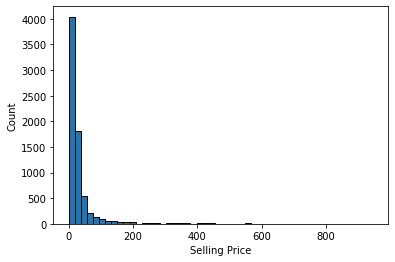

+-------+-----------------+
|summary|    Selling Price|
+-------+-----------------+
|  count|             7224|
|   mean|34.99135520487302|
| stddev|69.01885570629251|
|    min|             0.51|
|    25%|             10.0|
|    50%|            16.99|
|    75%|            29.99|
|    max|           945.99|
+-------+-----------------+

+--------------------+--------------------+----------------+-------------+-----------+
|            Uniqe id|            Category|Is Amazon Seller|Selling Price|Price range|
+--------------------+--------------------+----------------+-------------+-----------+
|4c69b61db1fc16e70...|Sports & Outdoors...|               Y|       237.68|       High|
|66d49bbed043f5be2...|Toys & Games | Le...|               Y|        99.95|       High|
|2c55cae269aebf538...|Toys & Games | Ar...|               Y|        34.99|       High|
|18018b6bc416dab34...|Toys & Games | Ho...|               Y|        28.91|   Moderate|
|e04b990e95bf73bbe...|Toys & Games | Pu...|           

In [27]:
# histogram of selling price
sp_pd = product_details.select('Selling Price').toPandas()
plt.hist(data=sp_pd, x="Selling Price", edgecolor = "black", bins=50)
plt.xlabel("Selling Price")
plt.ylabel("Count")
plt.show()

# selling price summary statistics
product_details.select('Selling Price').summary().show()

# create categories for selling price with low, moderate and high
product_details = product_details.withColumn("Price range", 
    when(col("Selling Price") < 10, "Low")
    .when((col("Selling Price") >= 10) & (col("Selling Price") < 30), "Moderate")
    .otherwise("High")
)

product_details.show()

### 3.4 Integrate Various Data Sources

In [28]:
# Merge customer details and sales data
merged_df = customer_details.join(sales_data, customer_details["Customer ID"] == sales_data["user id"], how='inner')

# merge product details to merged_df
merged_df = merged_df.join(product_details, product_details["Uniqe id"] == merged_df["product id"], how='inner')

# drop duplicate keys
merged_df = merged_df.drop('Uniqe id', 'user id')

### 3.5 Format Data

In [29]:
# attributes in merged_df
merged_df.printSchema()

# drop duplicate attributes and rows with any null value
merged_df = merged_df.drop('Category', 'Category')
merged_df = merged_df.dropna()

merged_df.printSchema()

root
 |-- Customer ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Item Purchased: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Subscription Status: string (nullable = true)
 |-- Discount Applied: string (nullable = true)
 |-- season_category: string (nullable = true)
 |-- product id: string (nullable = true)
 |-- Interaction type: string (nullable = true)
 |-- Time stamp: timestamp (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Is Amazon Seller: string (nullable = true)
 |-- Selling Price: double (nullable = true)
 |-- Price range: string (nullable = false)

root
 |-- Customer ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Item Purchased: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Subscription Status: string (nullable 

## 4 Data Transformation

### 4.1 Reduce Data

In [30]:
from pyspark.ml.feature import StringIndexer, ChiSqSelector, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

In [31]:
# List categorical columns
categorical_col = ['Gender','Item Purchased', 'season_category', 'Interaction type', 'Is Amazon Seller', 
                   'Price range', 'Discount Applied']

# Index categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_col]

# List feature columns
feature_col = ['Age','Gender','Item Purchased', 'season_category', 'Interaction type', 'day_of_week', \
               'Is Amazon Seller', 'Selling Price', 'Price range', 'Discount Applied']

# Index Subscription Status
ind_sub = StringIndexer(inputCol='Subscription Status', outputCol='Indexed Subscription Status')

# Fit and transform Subscription Status
merged_df = ind_sub.fit(merged_df).transform(merged_df)

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[col + "_index" if col in categorical_col else col for col in feature_col], \
                            outputCol="features")

# Build the pipeline
pipeline = Pipeline(stages=indexers + [assembler])

# Fit and transform the data
preprocessed_data = pipeline.fit(merged_df).transform(merged_df)

# Apply Chi-Squared Selector for feature selection
selector = ChiSqSelector(featuresCol="features", outputCol="selectedFeatures", \
                         labelCol="Indexed Subscription Status", numTopFeatures=5)

# Fit the selector to the preprocessed data
model = selector.fit(preprocessed_data)
selected_data = model.transform(preprocessed_data)

# Get the indices of the selected features
selected_indices = model.selectedFeatures

# Get the original feature names
assembler_input_cols = assembler.getInputCols()
selected_feature_names = [assembler_input_cols[i] for i in selected_indices]

# Show the selected feature names
print("Selected features:")
for feature in selected_feature_names:
    print(feature)

Selected features:
Gender_index
Interaction type_index
Selling Price
Price range_index
Discount Applied_index


### 4.2 Project Data

In [32]:
# Subscription Status class count
merged_df.groupBy("Subscription Status").count().show()

+-------------------+-----+
|Subscription Status|count|
+-------------------+-----+
|                 No| 1348|
|                Yes|  744|
+-------------------+-----+



In [33]:
# Separate yes and no of Subscription Status
df_yes = merged_df.filter(col("Subscription Status") == "Yes")
df_no = merged_df.filter(col("Subscription Status") == "No")

# Calculate the ratio for oversampling
yes_count = df_yes.count()
no_count = df_no.count()

# Perform oversampling
df_yes_boost = df_yes.sample(withReplacement=True, fraction=no_count / yes_count)

# Combine the boosted data with df_no
merged_df_boost = df_yes_boost.union(df_no)

merged_df_boost.groupBy("Subscription Status").count().show()

+-------------------+-----+
|Subscription Status|count|
+-------------------+-----+
|                Yes| 1377|
|                 No| 1348|
+-------------------+-----+



## 6 Data Mining Algorithm Selection

### 6.3 Build/Select Appropriate Model and Choose Relevant Parameters

In [34]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler

In [35]:
feat_cols = ['Age','day_of_week','Selling Price']
vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features')
final_data = vec_assembler.transform(merged_df_boost)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

# Normalize each feature to have unit standard deviation.
cluster_final_data = scalerModel.transform(final_data)

In [36]:
for k in range(2,9):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(cluster_final_data)
    predictions = model.transform(cluster_final_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("With K={}".format(k))
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    print('--'*30)

With K=2
Silhouette with squared euclidean distance = 0.050418324064464275
------------------------------------------------------------
With K=3
Silhouette with squared euclidean distance = 0.02577856227436922
------------------------------------------------------------
With K=4
Silhouette with squared euclidean distance = 0.08684322927052675
------------------------------------------------------------
With K=5
Silhouette with squared euclidean distance = -0.040284950058401305
------------------------------------------------------------
With K=6
Silhouette with squared euclidean distance = 0.0674333642245991
------------------------------------------------------------
With K=7
Silhouette with squared euclidean distance = 0.053326320590020834
------------------------------------------------------------
With K=8
Silhouette with squared euclidean distance = 0.0675203348408039
------------------------------------------------------------


In [37]:
from pyspark.ml.classification import RandomForestClassifier

In [47]:
# List categorical columns
categorical_col = ['Gender', 'Interaction type', 'Discount Applied']

# Index categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_col]

# List feature columns
feature_col = ['Gender', 'Interaction type', 'Selling Price', 'Discount Applied']

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[col + "_index" if col in categorical_col else col for col in feature_col], \
                            outputCol="features")

# Build the pipeline
pipeline = Pipeline(stages=indexers + [assembler])

# fit and transform the data
preprocessed_data = pipeline.fit(merged_df_boost).transform(merged_df_boost)

# Initialize Random Forest classifier
rfc = RandomForestClassifier(featuresCol="features", labelCol="Indexed Subscription Status")

## 7 Data Mining

### 7.1 Create and Justify Test Designs

In [49]:
# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = preprocessed_data.randomSplit([0.8, 0.2], seed=42)

### 7.2 Construct Data Mining

In [44]:
kmeans = KMeans(featuresCol='scaledFeatures',k=4)
model = kmeans.fit(cluster_final_data)
kmeans_predictions = model.transform(cluster_final_data)

0.08684322927052675
Cluster Centers:
[3.0758375  3.13000186 0.4698682 ]
[3.85140231 1.34734194 0.48578922]
[2.93364826 1.65018781 7.12336857]
[1.98089892 1.58547996 0.45386831]


In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [50]:
# fit train data and test data
rfc_model = rfc.fit(train_data)
rfc_predictions = rfc_model.transform(test_data)

0.8207171314741036


### 7.3 Search for Patterns

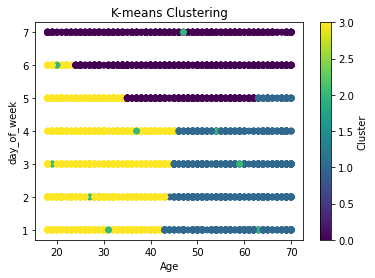

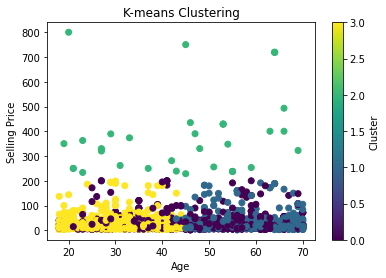

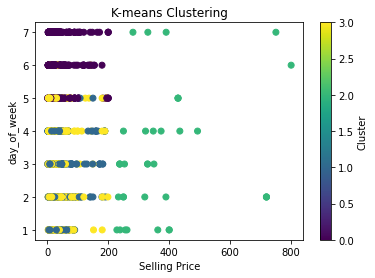

In [68]:
kmeans_predictions_pd = kmeans_predictions.toPandas()
plt.scatter(kmeans_predictions_pd["Age"], kmeans_predictions_pd["day_of_week"], c=kmeans_predictions_pd["prediction"], cmap='viridis')
plt.xlabel("Age")
plt.ylabel("day_of_week")
plt.title("K-means Clustering")
plt.colorbar().set_label("Cluster")
plt.show()

plt.scatter(kmeans_predictions_pd["Age"], kmeans_predictions_pd["Selling Price"], c=kmeans_predictions_pd["prediction"], cmap='viridis')
plt.xlabel("Age")
plt.ylabel("Selling Price")
plt.title("K-means Clustering")
plt.colorbar().set_label("Cluster")
plt.show()

plt.scatter(kmeans_predictions_pd["Selling Price"], kmeans_predictions_pd["day_of_week"], c=kmeans_predictions_pd["prediction"], cmap='viridis')
plt.xlabel("Selling Price")
plt.ylabel("day_of_week")
plt.title("K-means Clustering")
plt.colorbar().set_label("Cluster")
plt.show()

In [64]:
# show importance scores for each features
feature_importances = rfc_model.featureImportances
for i in range(len(feature_col)):
    feat_name = feature_col[i]
    feat_imp = feature_importances[i]
    print(feat_name + ':' + str(feat_imp))

Gender:0.09905077257846599
Interaction type:0.0022014103689720326
Selling Price:0.004961636428236788
Discount Applied:0.8937861806243251


## 8 Interpretation

### 8.2 Visualise the Data, Results, Models and Patterns

### 8.4 Assess and Evaluate Results, Models and Patterns

In [51]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(kmeans_predictions)
print(silhouette)

# show clusters center
centers = model.clusterCenters()
print("Cluster Centers:")
for center in centers:
    print(center)

0.08684322927052675
Cluster Centers:
[3.0758375  3.13000186 0.4698682 ]
[3.85140231 1.34734194 0.48578922]
[2.93364826 1.65018781 7.12336857]
[1.98089892 1.58547996 0.45386831]


In [52]:
# Evaluate classification accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Indexed Subscription Status", 
                                                  predictionCol="prediction", metricName="accuracy")
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
print(rfc_acc)

0.8207171314741036


### 8.5 Iteration Prior Steps (1 - 7)